In [16]:
import sys
from pathlib import Path

# Add parent directory to path so we can import from src
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import cv2 
import json
import matplotlib.pyplot as plt

from src.detect_card import detect_card
from src.extract_fields import extract_fields
from src.apply_ocr import run_ocr
from src.clean_text import clean_text

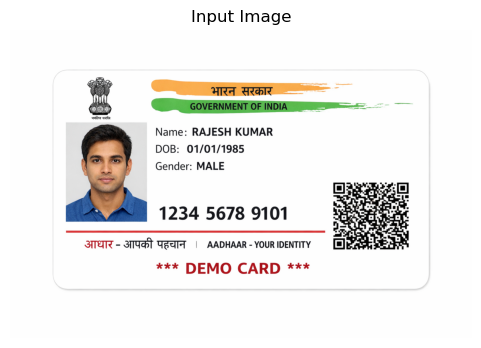

In [17]:
image_path=r'../demoimages/aadhar-1.png'

image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

In [18]:
card_type,card_box=detect_card(image)

print("Detected card type:",card_type)
print("Card bounding box",card_box)

Detected card type: aadhar
Card bounding box [          0           0      1533.6      1020.5]


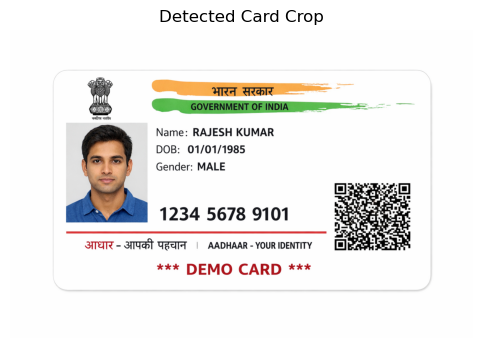

In [19]:
x1,y1,x2,y2=map(int,card_box)
card_crop=image[y1:y2,x1:x2]

plt.figure(figsize=(6,4))
plt.imshow(card_crop)
plt.axis("off")
plt.title("Detected Card Crop")
plt.show()

In [20]:
fields=extract_fields(card_crop,card_type)

print("Detected Fields:")
for f in fields:
    print(f['field_name'],f['box'])


Detected Fields:
aadhar_number [     491.42      573.74      928.81      639.99]
gender [     619.69      426.37      723.61      470.96]
name [     482.68      314.12      886.61      356.76]


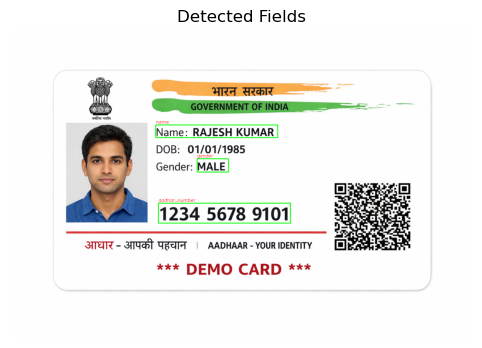

In [22]:
field_viz=card_crop.copy()

for f in fields:
    x1,y1,x2,y2=map(int,f['box'])
    cv2.rectangle(field_viz,(x1,y1),(x2,y2),(0,255,0),2)
    cv2.putText(field_viz,f["field_name"],(x1,y1-5),
    cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)

plt.figure(figsize=(6,4))
plt.imshow(field_viz)
plt.axis("off")
plt.title("Detected Fields")
plt.show()

In [24]:
final_data={}

for f in fields:
    field_name=f["field_name"]
    x1,y1,x2,y2=map(int,f['box'])

    crop=card_crop[y1:y2,x1:x2]
    
    raw_text=run_ocr(crop)
    cleaned_text=clean_text(field_name,raw_text)

    final_data[field_name]=cleaned_text
final_data

{'aadhar_number': '123456789101',
 'gender': 'Male',
 'name': 'Name: Rajesh Kumar'}

In [25]:
output={
    "document_type":card_type,
    "extracted_fields":final_data
}

print(json.dumps(output,indent=4))

{
    "document_type": "aadhar",
    "extracted_fields": {
        "aadhar_number": "123456789101",
        "gender": "Male",
        "name": "Name: Rajesh Kumar"
    }
}


In [26]:
if len(final_data)==0:
    print("No fields extracted.Possible resons:")
    print("- Poor image quality")
    print("- Low lighting")
    print("- OCR failure")